In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numpy version :  1.21.6
pandas version :  1.3.5
seaborn version :  0.11.2


In [3]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load Dataset

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Dibimbing/Day 23 - Exploring Other Machine Learning Models With Python (Unsupervised) Part II/flight.csv')
data = data.dropna()
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
5,56972,2/10/2008,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,3/31/2014,...,76946.0,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15


# Data Understanding

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58255 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          58255 non-null  int64  
 1   FFP_DATE           58255 non-null  object 
 2   FIRST_FLIGHT_DATE  58255 non-null  object 
 3   GENDER             58255 non-null  object 
 4   FFP_TIER           58255 non-null  int64  
 5   WORK_CITY          58255 non-null  object 
 6   WORK_PROVINCE      58255 non-null  object 
 7   WORK_COUNTRY       58255 non-null  object 
 8   AGE                58255 non-null  float64
 9   LOAD_TIME          58255 non-null  object 
 10  FLIGHT_COUNT       58255 non-null  int64  
 11  BP_SUM             58255 non-null  int64  
 12  SUM_YR_1           58255 non-null  float64
 13  SUM_YR_2           58255 non-null  float64
 14  SEG_KM_SUM         58255 non-null  int64  
 15  LAST_FLIGHT_DATE   58255 non-null  object 
 16  LAST_TO_END        582

# Data Preprocessing

## Check Null and Missing Values 

In [6]:
data_null = data.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage


## Duplicate Values

In [7]:
# check duplicates values
data.duplicated().sum()

0

## Statistical Summary

In [8]:
# statistical summary
data.describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000
mean,31545.754854,4.104849,42.228736,12.067634,11066.303682,5366.827963,5694.530650,17353.000910,171.255309,67.937285,167.349206,0.328384,0.720627,12742.648820,2.820548
std,18187.496028,0.378182,9.761965,14.236472,16283.209178,8103.595049,8710.724917,20969.886756,180.560120,77.449058,122.890446,1.148485,0.183895,20606.104272,7.500252
min,3.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15787.500000,4.000000,35.000000,3.000000,2608.000000,1016.000000,846.000000,4904.000000,28.000000,23.700000,81.000000,0.000000,0.612155,2872.500000,0.000000
50%,31603.000000,4.000000,41.000000,7.000000,5832.000000,2808.000000,2846.000000,10237.000000,104.000000,44.833333,144.000000,0.000000,0.711468,6487.000000,0.000000
75%,47315.500000,4.000000,48.000000,15.000000,13022.000000,6591.500000,6958.000000,21571.500000,258.000000,82.000000,228.000000,0.000000,0.808159,14527.000000,1.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


In [9]:
data = data.drop('MEMBER_NO', axis=1)

## Numeric Distribution and Outlier

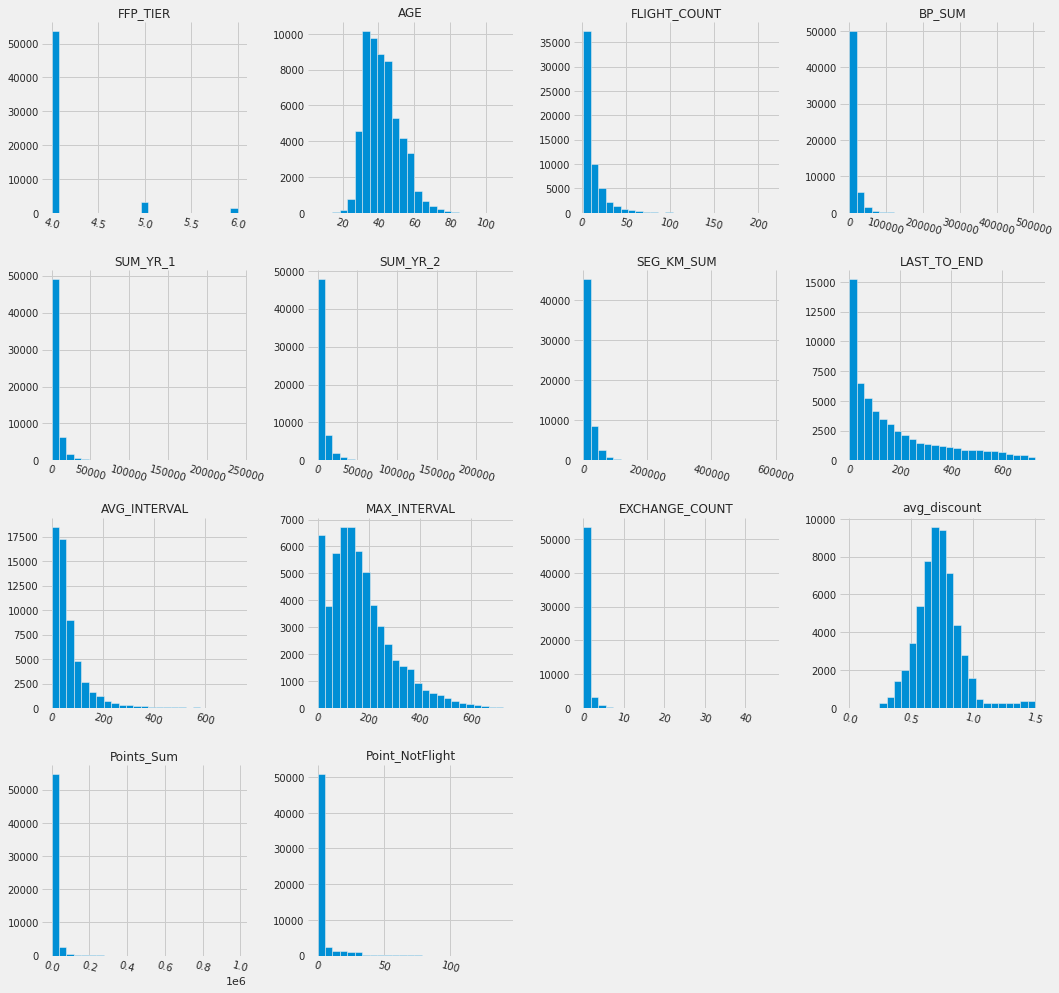

In [10]:
h = data.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [11]:
feat_num = list(data.select_dtypes(['int64', 'float64']))

In [12]:
len(feat_num)

14

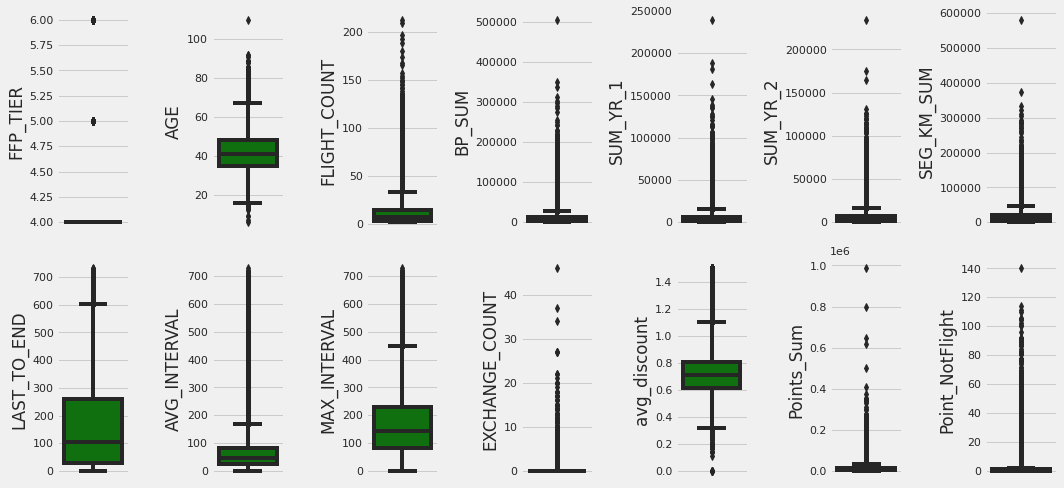

In [13]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=data[feat_num[i]],color='green',orient='v')
    plt.tight_layout()

## Correlation Matrix

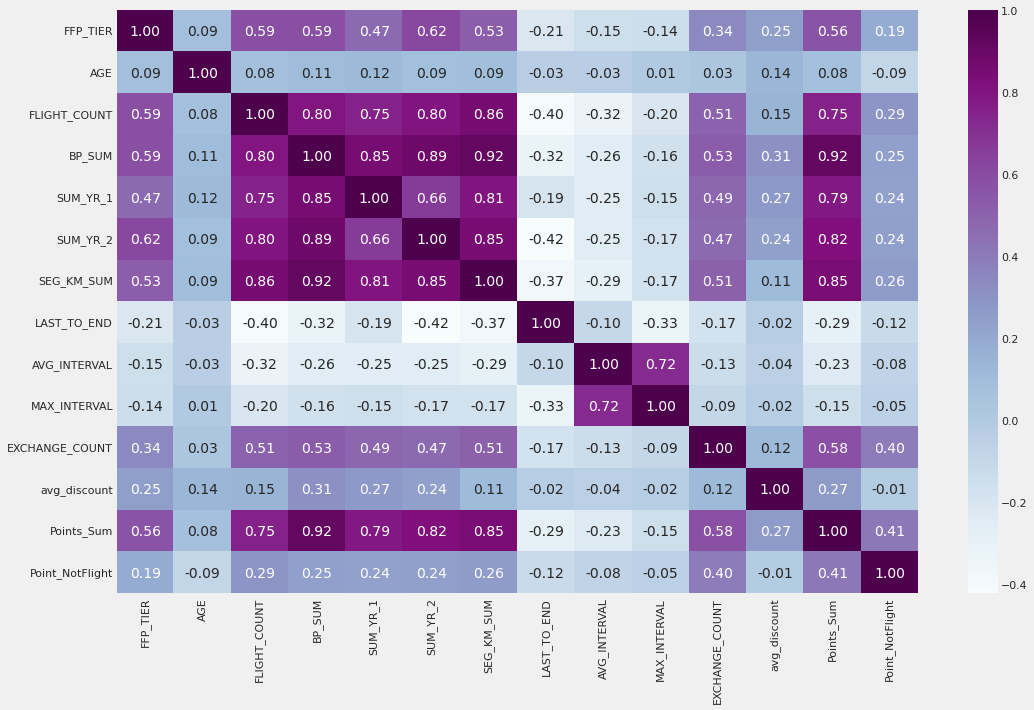

In [14]:
corr_= data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

# Feature Selection

**LRFMC**

## Loyalty (L)

The number of months between the time of membership and the end of observation window = the end of observation - the time of membership [unit: month]

In [15]:
data['LOAD_TIME'] = pd.to_datetime(data['LOAD_TIME'])
data['FFP_DATE'] = pd.to_datetime(data['FFP_DATE'])

In [16]:
data['L'] = data['LOAD_TIME'] - data['FFP_DATE']

In [17]:
data['L'] = data['L'].astype('timedelta64[D]').astype(int)

In [18]:
data.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,L
0,2006-11-02,12/24/2008,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50,2706
2,2007-02-01,8/30/2007,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26,2615
3,2008-08-22,8/23/2008,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12,2047
4,2009-04-10,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39,1816
5,2008-02-10,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15,2241


## Recency

The number of months from the last time the customer took the company's aircraft to the end of the observation window = the time from the last flight to the end of the observation window [unit: month]

In [19]:
#data['LAST_FLIGHT_DATE'] = pd.to_datetime(data['LAST_FLIGHT_DATE']) -> Error for date 2014/2/29, meanwhile 2014 is not a leap (kabisat) year
error_date = data[data['LAST_FLIGHT_DATE'].str.contains('2014/2/29')].index

In [20]:
data = data.drop(error_date)

In [21]:
data['LAST_FLIGHT_DATE'] = pd.to_datetime(data['LAST_FLIGHT_DATE'])

In [22]:
data['R'] = data['LOAD_TIME'] - data['LAST_FLIGHT_DATE']

In [23]:
data['R'] = data['R'].astype('timedelta64[D]').astype(int)

In [24]:
data.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,L,R
0,2006-11-02,12/24/2008,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,2014-03-31,1,3.483254,18,34,0.961639,619760,50,2706,0
2,2007-02-01,8/30/2007,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,2014-03-21,11,5.298507,18,20,1.254676,406361,26,2615,10
3,2008-08-22,8/23/2008,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,2013-12-26,97,27.863636,73,11,1.090870,372204,12,2047,95
4,2009-04-10,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,2014-03-27,5,4.788079,47,27,0.970658,338813,39,1816,4
5,2008-02-10,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,2014-01-13,79,7.043956,52,10,0.967692,343121,15,2241,77


## Frequency

Number of times the customer takes the company's aircraft in the observation window = number of flights in the observation window [unit: Times]

In [25]:
data['F'] = data['FLIGHT_COUNT']

In [26]:
data.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,L,R,F
0,2006-11-02,12/24/2008,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,1,3.483254,18,34,0.961639,619760,50,2706,0,210
2,2007-02-01,8/30/2007,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,11,5.298507,18,20,1.254676,406361,26,2615,10,135
3,2008-08-22,8/23/2008,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,97,27.863636,73,11,1.090870,372204,12,2047,95,23
4,2009-04-10,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,5,4.788079,47,27,0.970658,338813,39,1816,4,152
5,2008-02-10,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,79,7.043956,52,10,0.967692,343121,15,2241,77,92


## Monetary

Accumulated flight history of the customer in observation time = total flight kilometers of observation window [unit: km]

In [27]:
data['M'] = data['SEG_KM_SUM']

In [28]:
data.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,L,R,F,M
0,2006-11-02,12/24/2008,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,3.483254,18,34,0.961639,619760,50,2706,0,210,580717
2,2007-02-01,8/30/2007,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,5.298507,18,20,1.254676,406361,26,2615,10,135,283712
3,2008-08-22,8/23/2008,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,27.863636,73,11,1.090870,372204,12,2047,95,23,281336
4,2009-04-10,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,4.788079,47,27,0.970658,338813,39,1816,4,152,309928
5,2008-02-10,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,7.043956,52,10,0.967692,343121,15,2241,77,92,294585


## Cabin

Average value of discount coefficient corresponding to the passenger space during the observation time = average discount rate [unit: none]

In [29]:
data['C'] = data['avg_discount']

In [30]:
data.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,L,R,F,M,C
0,2006-11-02,12/24/2008,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,18,34,0.961639,619760,50,2706,0,210,580717,0.961639
2,2007-02-01,8/30/2007,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,18,20,1.254676,406361,26,2615,10,135,283712,1.254676
3,2008-08-22,8/23/2008,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,73,11,1.090870,372204,12,2047,95,23,281336,1.090870
4,2009-04-10,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,47,27,0.970658,338813,39,1816,4,152,309928,0.970658
5,2008-02-10,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,52,10,0.967692,343121,15,2241,77,92,294585,0.967692


In [31]:
data = data[['L', 'R', 'F', 'M', 'C']]

In [32]:
data.head()

,L,R,F,M,C
0,2706,0,210,580717,0.961639
2,2615,10,135,283712,1.254676
3,2047,95,23,281336,1.090870
4,1816,4,152,309928,0.970658
5,2241,77,92,294585,0.967692


# Scaling

In [33]:
sc_data = StandardScaler()
data_std = sc_data.fit_transform(data.astype(float))

# Evaluasi

## Inertia

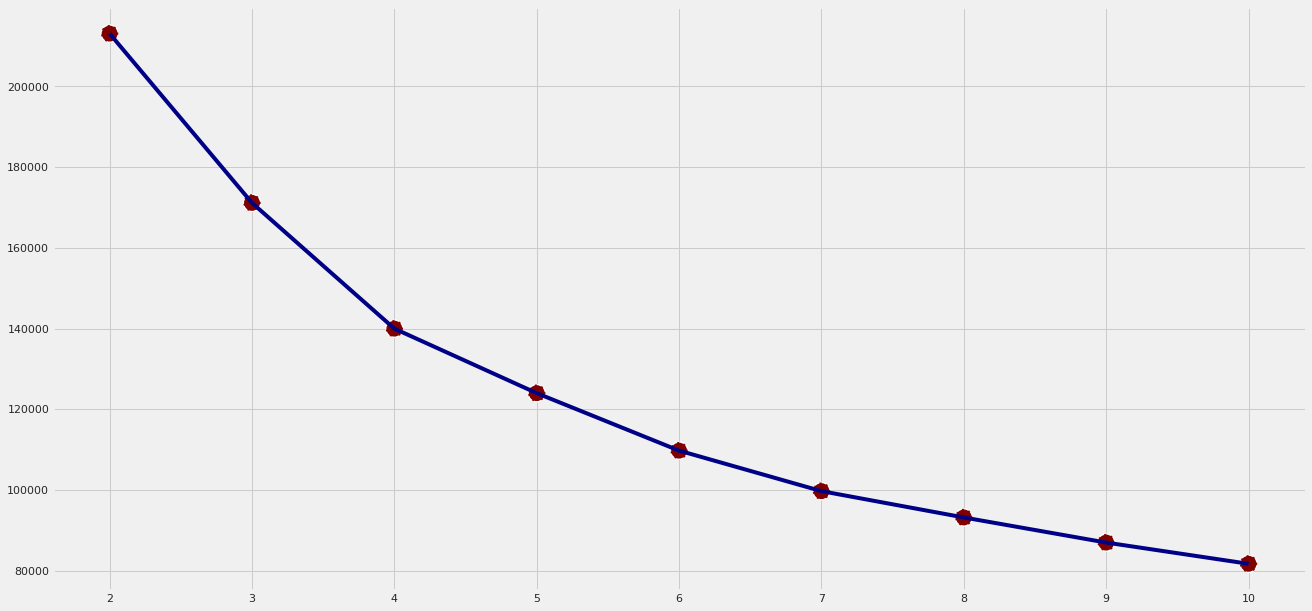

In [34]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))
# plt.plot(inertia)

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')

Nilai k=4 pada Elbow method adalah nilai k yang memiliki siku yang optimal

In [35]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_std)

In [36]:
df_data_std = pd.DataFrame(data=data_std, columns=list(data))
df_data_std.head()

,L,R,F,M,C
0,1.482461,-0.944097,13.902061,26.850528,1.310280
1,1.374135,-0.888716,8.634985,12.695673,2.903386
2,0.697994,-0.417983,0.769485,12.582436,2.012847
3,0.423014,-0.921945,9.828855,13.945092,1.359311
4,0.928929,-0.517668,5.615194,13.213865,1.343190


In [37]:
df_data_std['clusters'] = kmeans.labels_
data['clusters'] = kmeans.labels_

In [38]:
data.head()

,L,R,F,M,C,clusters
0,2706,0,210,580717,0.961639,2
2,2615,10,135,283712,1.254676,2
3,2047,95,23,281336,1.090870,2
4,1816,4,152,309928,0.970658,2
5,2241,77,92,294585,0.967692,2


In [39]:
pca = PCA(n_components=2)

pca.fit(data_std)
pcs = pca.transform(data_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = kmeans.labels_
data_pca.head()

,PC 1,PC 2,clusters
0,25.774432,-2.381297,2
1,14.154152,0.834026,2
2,8.744072,0.540390,2
3,15.188295,-1.098931,2
4,12.106803,-0.411840,2


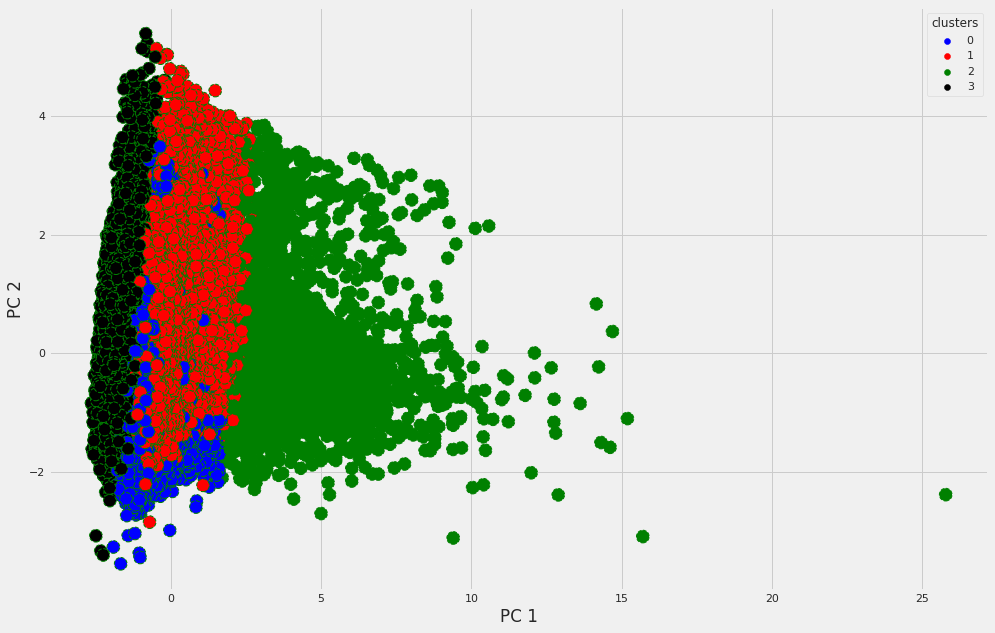

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green','black'],
    s=160,
    ax=ax
)

In [41]:
display(data.groupby('clusters').agg(['median']))

,L,R,F,M,C
,median,median,median,median,median
clusters,,,,,
0,833.0,77.0,8.0,10655.0,0.694000
1,2400.0,77.0,9.0,12419.5,0.721052
2,1890.0,12.0,42.0,58616.0,0.752304
3,973.0,461.0,3.0,4386.5,0.714437


# Insight

Terdapat 4 Cluster:
  - Cluster 0 (Customer Grup 1)
  - Cluster 1 (Customer Grup 2)
  - Cluster 2 (Customer Grup 3)
  - Cluster 3 (Customer Grup 4)

Clusters users terbentuk karena terdapat user yang memiliki nilai tinggi atau rendah terhadap fitur LRFMC

* Cluster 0
  - User baru (paling baru) jika dibandingkan dengan user pada cluster lain karena nilai pada fitur L-nya paling rendah
  - Jarak terakhir kali penerbangan(R), Jumlah penerbangan(F), dan Jauh penerbangan(M) termasuk dalam average
  - User yang rata-rata discount-nya(C) paling rendah

* Cluster 1
  - User lama (paling lama) jika dibandingkan dengan user pada cluster lain karena nilai pada fitur L-nya paling tinggi
  - Jarak terakhir kali penerbangan(R), Jumlah penerbangan(F), Jauh penerbangan(M), dan average discount-nya(C) termasuk dalam nilai average

* Cluster 2
  - Termasuk pelanggan lama dibuktikan dengan nilai pada fitur L-nya yang tinggi
  - Customer dengan jumlah penerbangan(F) paling sering/banyak, dibuktikan dengan nilai jarak terakhir kali penerbangan(R) paling rendah dan nilai jauh penerbangan(M) yang paling besar
  - Customer dengan average discount terbesar dengan nilai fitur C terbesar 

* Cluster 3
  - Juga termasuk user baru, tidak jauh berbeda dari cluster 0 dengan nilai fitur L yang tidak terlalu besar
  - Nilai jarak terakhir kali penerbangan(R)-nya paling tinggi dan nilai jumlah penerbangan(F)-nya paling rendah sehingga dapat dikatakan paling jarang terbang dibanding cluster lain
  - Nilai C-nya termasuk average walaupun lebih besar dari Cluster 0

Recommendation:
- Untuk cluster 0, Jarak terakhir kali penerbangan(R), Jumlah penerbangan(F), dan Jauh penerbangan(M) sudah termasuk bagus (average) namun dapat diberikan penambahan atau variasi discount yang lain agar tetap loyal.
- Untuk cluster 1, overall semua sudah baik
- Untuk cluster 2, sudah sangat baik
- Untuk cluster 3, dapat memberikan penambahan atau variasi discount yang lain agar tetap loyal.